In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
players<-read_csv("players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


In [3]:
players<-players|>
select(experience, subscribe, played_hours)
players

experience,subscribe,played_hours
<chr>,<lgl>,<dbl>
Pro,TRUE,30.3
Veteran,TRUE,3.8
Veteran,FALSE,0.0
Amateur,TRUE,0.7
Regular,TRUE,0.1
⋮,⋮,⋮
Amateur,TRUE,0.0
Veteran,FALSE,0.3
Amateur,FALSE,0.0


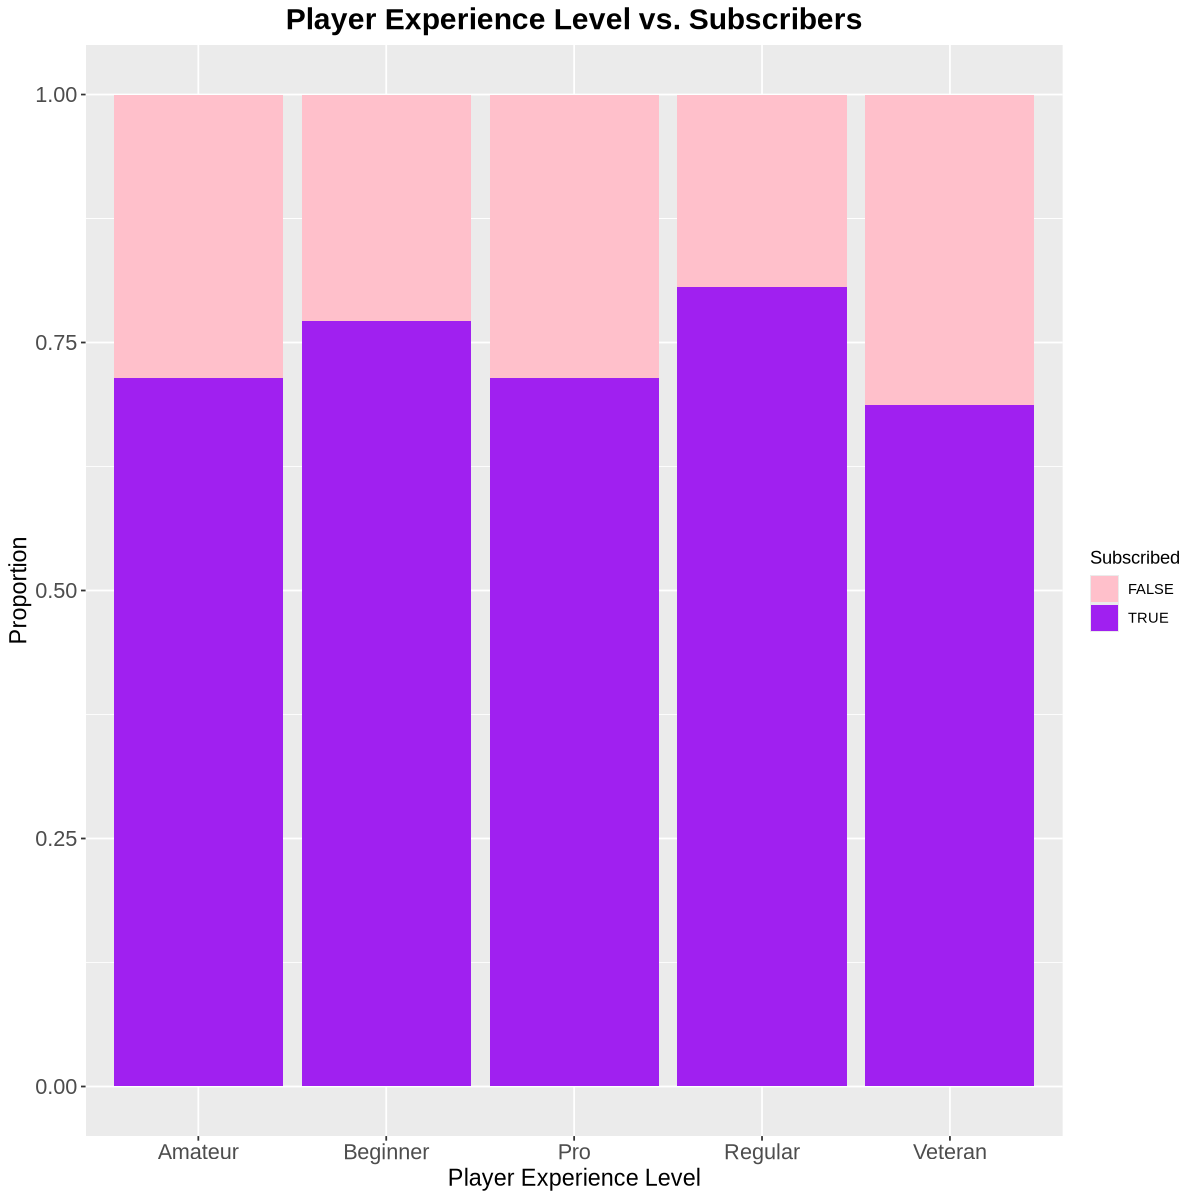

In [37]:
options(repr.plot.width = 10, repr.plot.height = 10) 
player_experience_plot<-players|>
ggplot(aes(x=experience, fill=subscribe))+
geom_bar(position="fill")+
labs(x="Player Experience Level", y="Proportion", fill="Subscribed")+
scale_fill_manual(values = c("TRUE" = "purple", "FALSE" = "pink")) +
ggtitle("Player Experience Level vs. Subscribers")+
theme(plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),  
axis.title = element_text(size = 14),                             
axis.text = element_text(size = 13))
player_experience_plot


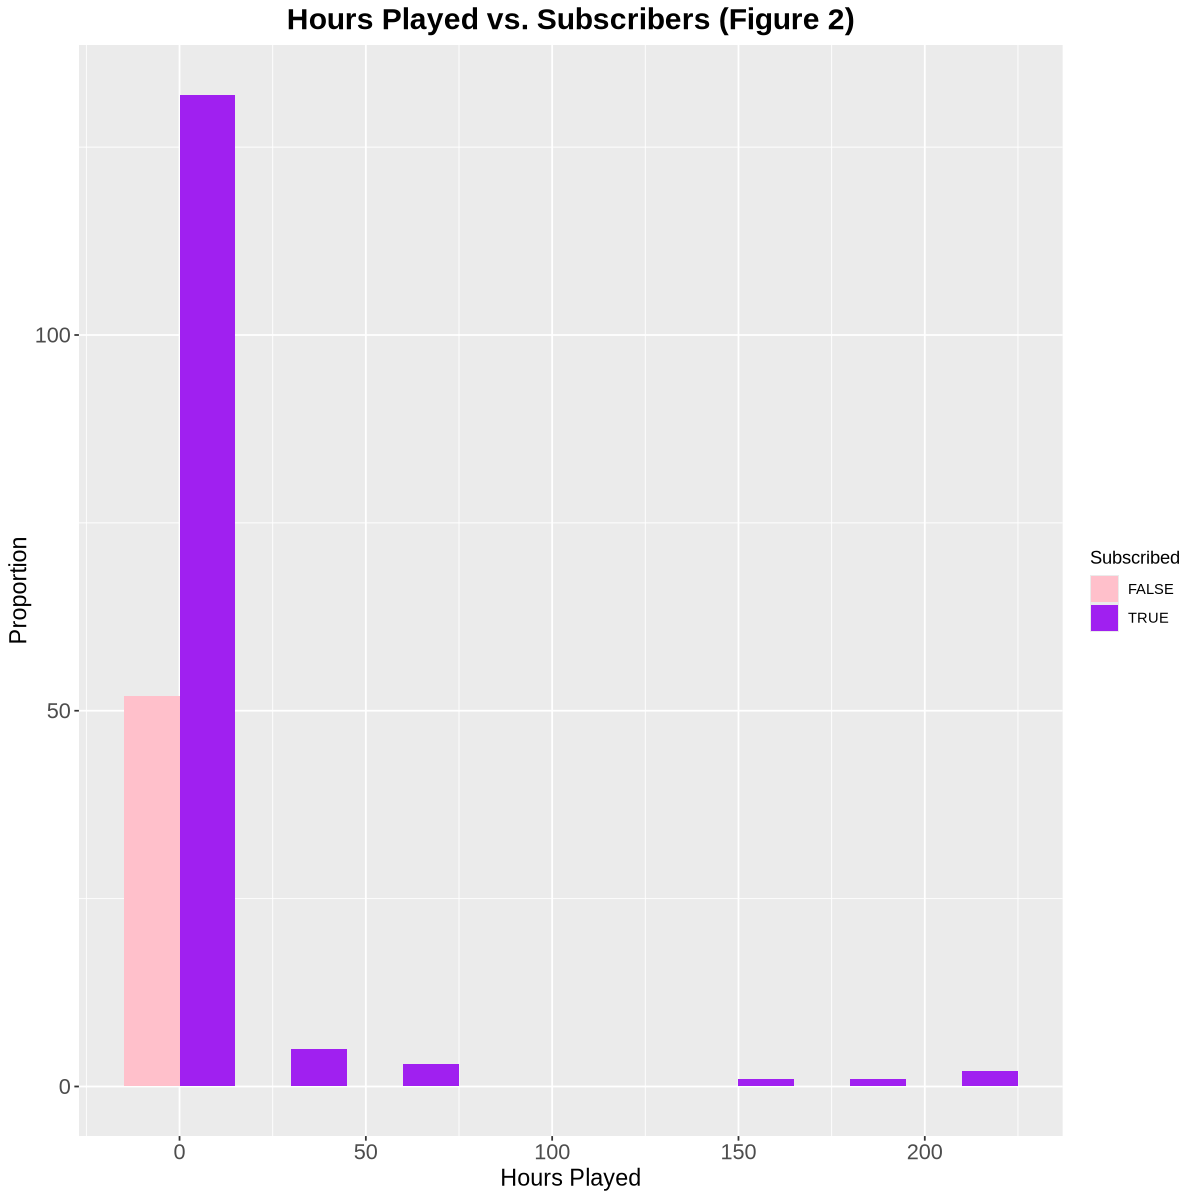

In [45]:
options(repr.plot.width = 10, repr.plot.height = 10) 
hours_played_plot<-players|>
ggplot(aes(x=played_hours, fill=subscribe))+
geom_histogram(position="dodge", binwidth=30)+
labs(x="Hours Played", y="Proportion", fill="Subscribed")+
scale_fill_manual(values = c("TRUE" = "purple", "FALSE" = "pink")) +
ggtitle("Hours Played vs. Subscribers (Figure 2)")+
theme(plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),  
axis.title = element_text(size = 14),                             
axis.text = element_text(size = 13))
hours_played_plot
